<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/dask_icon.svg"
     width="20%"
     align="right"
     alt="Dask logo\" />

# Dask DataFrame

---

[`dask.dataframe`](https://docs.dask.org/en/latest/dataframe.html) is an interface that mimics the pandas interface, for parallel and distributed workflows. It automatically builds parallel computations for tabular data.

**Note:** The term "Dask DataFrame" is overloaded, it can refer to the API or the object based on context. To avoid confusion, throughout this tutorial:
* `dask.dataframe` (note the lowercase) refers to the overall API, and
* `dask.dataframe.DataFrame`, or simply, `DataFrame` (note the CamelCase) refers to the object.

## Dask DataFrame data model

For the most part, a Dask DataFrame feels like a pandas DataFrame, and can can serve as a drop-in replacement for pandas DataFrame.

However, internally a Dask DataFrame is composed of many pandas DataFrames as shown below. 

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="30%">

Dask DataFrames are partitioned along their index into different **partitions** where each parition is a normal pandas DataFrame. These pandas objects may live on disk or on other machines.

`dask.dataframe` implements a well-used portion of the pandas API, which are backed by **blocked algorithms** that allow for parallel and out-of-core computation. In particular, `dask.dataframe` supports:

- Element-wise operations: `df.x` + `df.y`, `df * df`

- Row-wise selections: `df[df.x > 0]`

- Loc: `df.loc[4.0:10.5]`

- Common aggregations: `df.x.max()`, `df.max()`

- Is in: `df[df.x.isin([1, 2, 3])]`

- Datetime/string accessors: `df.timestamp.month`

- Groupby-aggregate (with common aggregations): `df.groupby(df.x).y.max()`, `df.groupby('x').max()`

among many others.

For more details about what pandas operations are implemented in Dask, see the [API documentation](http://docs.dask.org/en/latest/dataframe-api.html).

### Sidenote: Blocked Algorithms

Blocked algorithms compute a large result like "take the sum of these trillion numbers" with many small computations like "break up the trillion numbers into one million chunks of size one million, sum each chunk, then sum all of the intermediate sums." Through tricks like this we can evaluate one large problem by solving very many small problems.

## When to use Dask DataFrames

pandas is great for tabular datasets that fit in memory. If your data fits in memory then you should use pandas. **Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM** where you would normally run into `MemoryError`s.

```python
    MemoryError:  ...
```

During this tutorial, the example NYC dataset we're working with is only about 200MB so that you can download it in a reasonable time and exercises finish quickly, but Dask DataFrames will scale to datasets much larger than the memory on your local machine.

## Getting started with Dask DataFrames

### Create the required datasets

In [1]:
%run ../prep_data.py -d flights

data_dir='/Users/pavithraes/Developer/Dask/dask-mini-tutorial/data'


### Read the data

Let's use `dask.dataframe` to explore our NYC flight dataset. Dask's `read_csv` function will automatically parse wildcard characters like `"*"` which can, for example, be used to load an entire directory of CSV files.

In [2]:
import os

files = os.path.join('../data', 'nycflights', '*.csv')
files

'../data/nycflights/*.csv'

In [3]:
import dask.dataframe as dd

In [4]:
ddf = dd.read_csv(files)
ddf

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Notice that the representation of the DataFrame object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and `dtypes`.

#### Sidenote: Lazy Evaluation

This is also known as "lazy" reading, more broadly, **lazy evaluation**. A "lazy" Dask object holds everything you need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another. You can evaluate the result with `.compute()` or you can visualize the task graph for this value with `.visualize()`. This will be discussed in detail in the Delayed notebook!

You can view the start of the data with `ddf.head()` and end of the data with `ddf.tail()`. These trigger a computation to show the corresponding rows of the DataFrame.

In [5]:
ddf.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [6]:
ddf.tail()

# Fails with
# 
# ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

# +----------------+---------+----------+
# | Column         | Found   | Expected |
# +----------------+---------+----------+
# | CRSElapsedTime | float64 | int64    |
# | TailNum        | object  | float64  |
# +----------------+---------+----------+

# The following columns also raised exceptions on conversion:

# - TailNum
#   ValueError("could not convert string to float: 'N54711'")

# Usually this is due to dask's dtype inference failing, and
# *may* be fixed by specifying dtypes manually by adding:

# dtype={'CRSElapsedTime': 'float64',
#        'TailNum': 'object'}

# to the call to `read_csv`/`read_table`.

Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first `n` rows have no value for `CRSElapsedTime` (which pandas infers as a float), and later on turn out to be strings (object dtype). Note that Dask gives an informative error message about the mismatch. When this happens you have a few options:

* Specify `dtypes` directly using the dtype keyword. This is the recommended solution, as its the least error prone (better to be explicit than implicit) and also the most performant.
* Increase the size of the `sample` keyword (in bytes).
* Use `assume_missing` to make Dask assume that columns inferred to be `int` (which don't allow missing values) are actually `floats` (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the `dtypes` of the offending columns.

In [7]:
ddf = dd.read_csv(files,
                  parse_dates={'Date': [0, 1, 2]},
                  dtype={"TailNum": str,
                         "CRSElapsedTime": float,
                         "Cancelled": bool})
ddf

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
ddf.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


In [9]:
ddf.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


In [10]:
ddf.columns

Index(['Date', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted'],
      dtype='object')

In [11]:
ddf.dtypes

Date                 datetime64[ns]
DayOfWeek                     int64
DepTime                     float64
CRSDepTime                    int64
ArrTime                     float64
CRSArrTime                    int64
UniqueCarrier                object
FlightNum                     int64
TailNum                      object
ActualElapsedTime           float64
CRSElapsedTime              float64
AirTime                     float64
ArrDelay                    float64
DepDelay                    float64
Origin                       object
Dest                         object
Distance                    float64
TaxiIn                      float64
TaxiOut                     float64
Cancelled                      bool
Diverted                      int64
dtype: object

`dask.dataframe` has an `.npartitions` attribute which tells you how many pandas DataFrames make up a Dask DataFrame.

In [12]:
ddf.npartitions

10

Let's look at the task graph for our Dask DataFrame to get a sense for where these partitions are coming from:

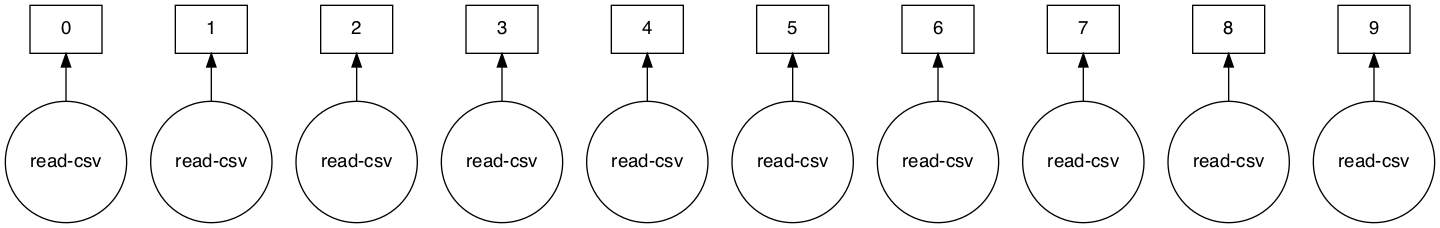

In [13]:
ddf.visualize()

Each partition in our Dask DataFrame is the result of calling pandas' `read_csv` on an input CSV file in our dataset.

#### Sidenote: Distributed Scheduler

As you might have noticed we can perform computations on Dask DataFrames using the single machine scheduler, but we recommend you use a distributed cluster so you can see the dashboard in action. Schedulers will be discussed in detail later.

In [14]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53799,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:53818,Total threads: 3
Dashboard: http://127.0.0.1:53819/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53803,


**Don't forget to open the Dashboard!**

You can also read remote data directly. This is especially recommended if you're running Dask on the cloud:

```python
ddf = dd.read_parquet(
    "s3://nyc-tlc/trip data/yellow_tripdata_2012-*.parquet",
)
ddf.head()
```

## Computations with Dask DataFrames

Since `dask.dataframe` implements a pandas-like API, we can write familiar looking pandas code using our Dask DataFrames. For example, let's compute the largest flight departure delay.

In pandas you would do this by iterating over each file to find the individual maximums and then find the final maximum over the individual maximums.

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df["DepDelay"].max())

final_max = max(maxes)
```

You can do this with Dask DataFrame using pandas-like code:

In [15]:
max_delay = ddf["DepDelay"].max()
max_delay

dd.Scalar<series-..., dtype=float64>

Note: Again, this is evaluated lazily. Dask has not performed any computation yet, it has just created the required task graph that can be computed in parallel.

Let's look at the task graph to get a feel for how Dask's blocked algorithms work:

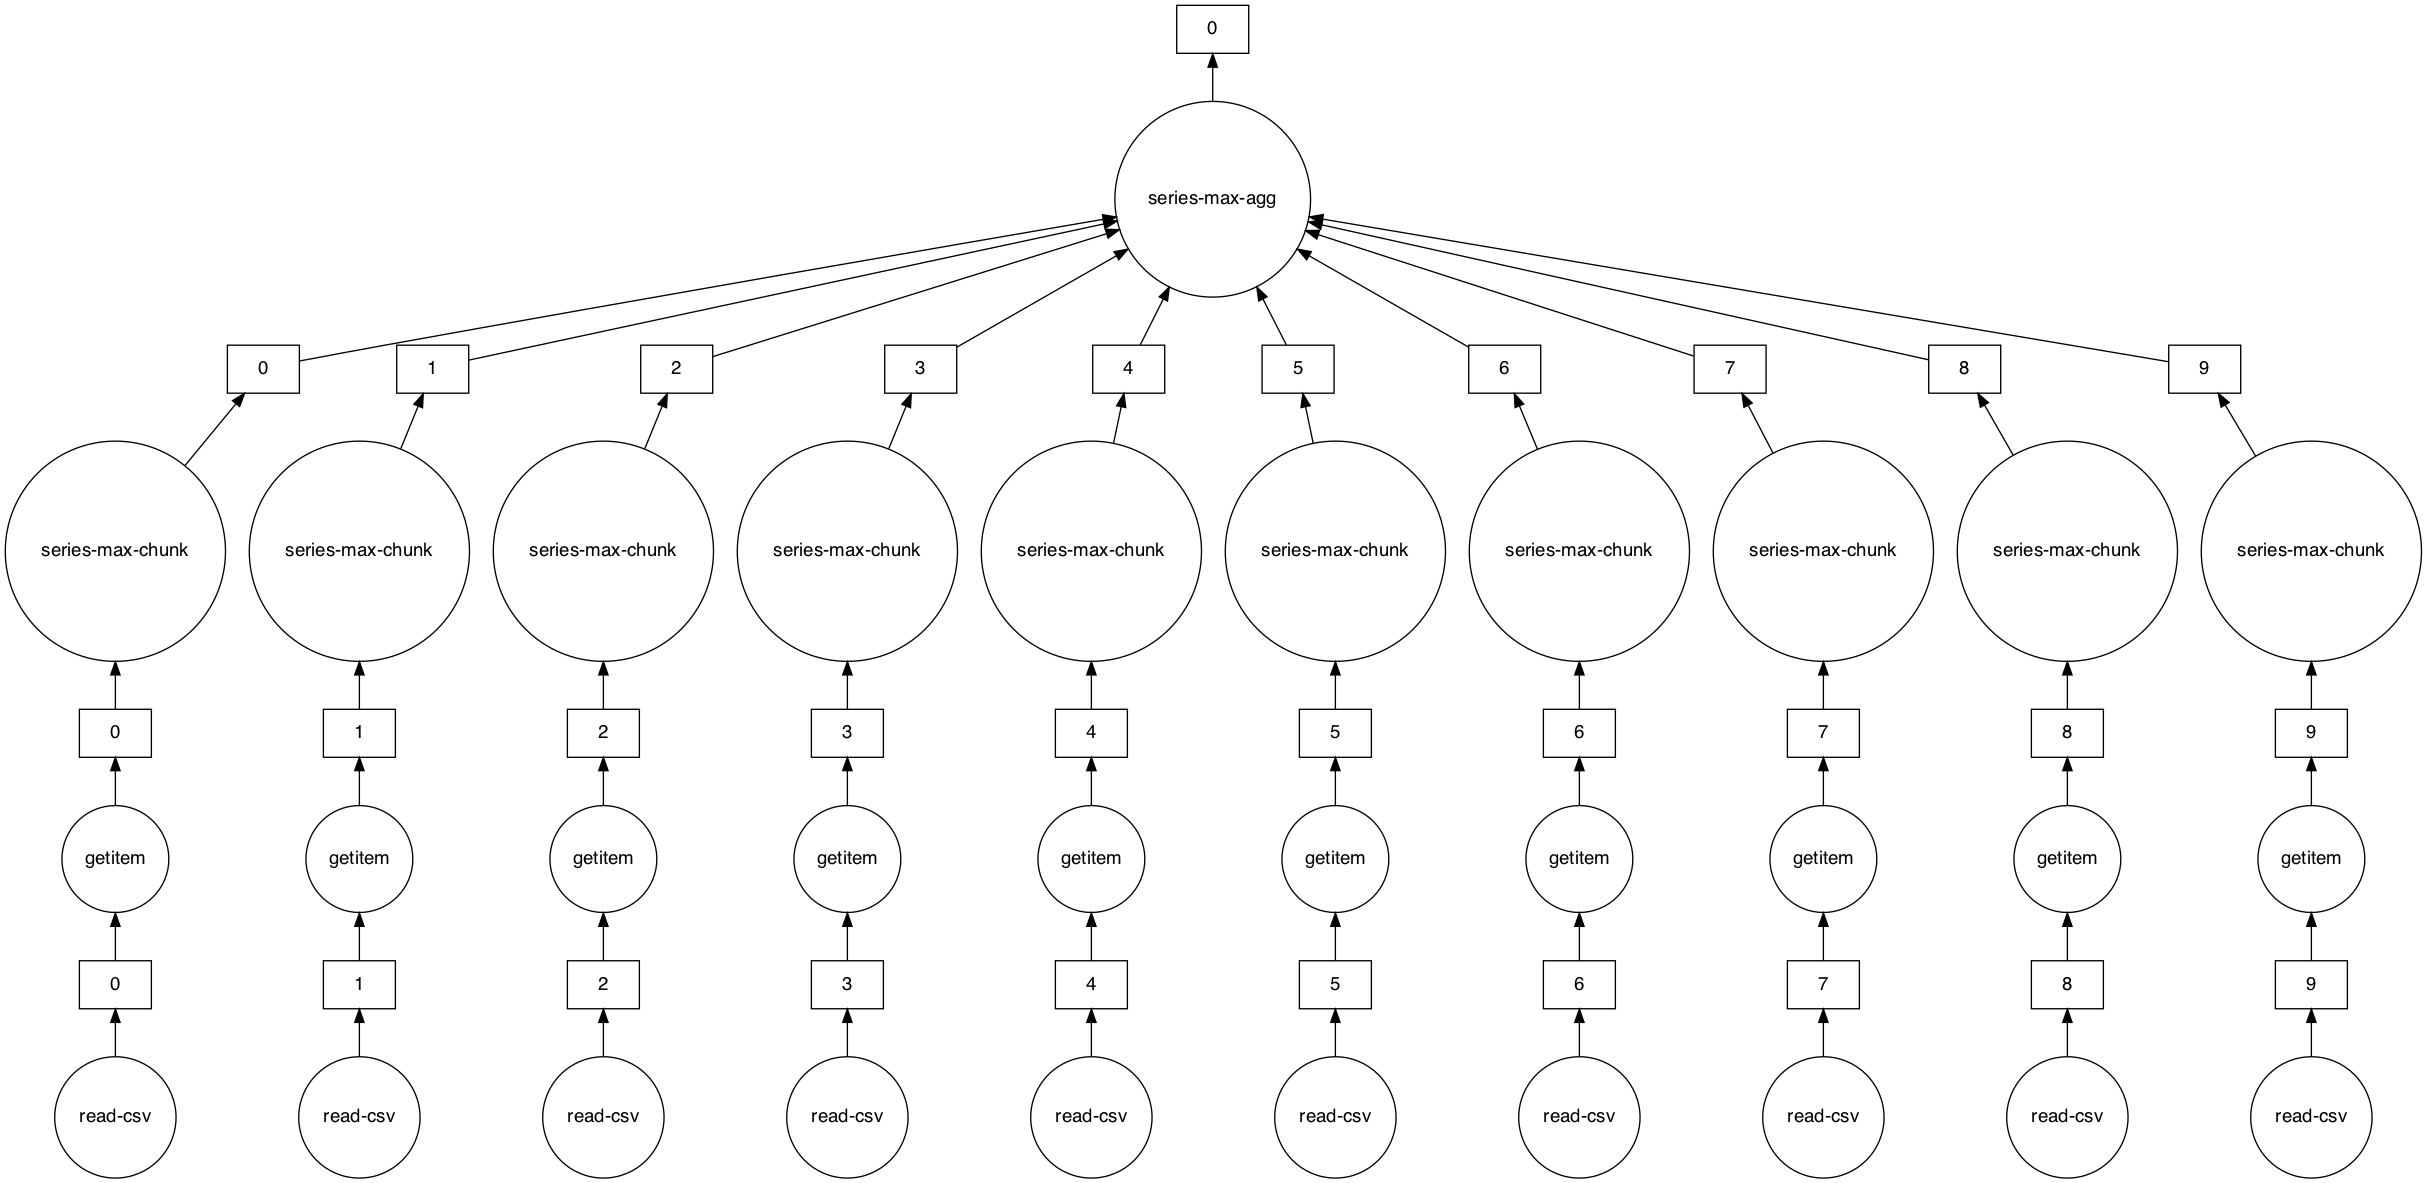

In [16]:
max_delay.visualize()

To evaluate the result for `max_delay`, call its `compute()` method:

In [17]:
%%time 
max_delay.compute()

CPU times: user 267 ms, sys: 121 ms, total: 388 ms
Wall time: 2.64 s


1435.0

Note that Dask will **delete intermediate results** (like the full pandas DataFrame for each file) as soon as possible.
*  This lets us handle datasets that are larger than memory.
*  This means that repeated computations will have to load all of the data in each time.

### pandas' like computations

Let's see a couple of examples on how the API for Dask DataFrames is the same than pandas. If you are comfortable with pandas, the following operations will look very familiar, except we will need to add the `compute()` to get the results wanted.

#### Example 1: Total of non-canelled flights taken

Notice that there is a column in our DataFrame called `"Cancelled"` that is a boolean. 

In [18]:
(~ddf["Cancelled"]).sum().compute()

2540961

#### Example 2: Total of non-canceled flights taken by airport

You need to select the non-canceled flights, use the operation `groupby` on the `"Origin"` column and finally use `count` to get the detailed per airport.

In [19]:
ddf[~ddf["Cancelled"]].groupby("Origin")["Origin"].count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

#### Exercise 1: What is the average departure delay from each airport?

In [ ]:
#soultion
ddf.groupby("Origin")["DepDelay"].mean().compute()

#### Exercise 2: What day of the week has the worst average departure delay?

In [ ]:
#solution
ddf.groupby("DayOfWeek")["DepDelay"].mean().idxmax().compute()

### Performance tip: Share intermediate results


In the examples and exercises above, we sometimes perform the same operation more than once (e.g., `read_csv`). For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, let's compute the mean and standard deviation for departure delay of all non-canceled flights. Since Dask operations are lazy, those values aren't the final results until we `compute` them. They're just the recipe required to get the result.

If we compute them with two calls to compute, there is no sharing of intermediate computations.

In [22]:
non_cancelled = ddf[~ddf["Cancelled"]]
mean_delay = non_cancelled["DepDelay"].mean()
std_delay = non_cancelled["DepDelay"].std()

In [23]:
%%time

mean_delay_result = mean_delay.compute()
std_delay_result = std_delay.compute()

CPU times: user 244 ms, sys: 42.5 ms, total: 286 ms
Wall time: 4 s


Now, let's see how long it takes if we try computing `mean_delay` and `std_delay` with a single `compute()` call.

In [24]:
import dask

In [25]:
%%time
mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 151 ms, sys: 24.2 ms, total: 175 ms
Wall time: 2.01 s


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations (like `read_csv`) to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- The calls to `read_csv`
- The filter (`df[~df["Cancelled"]]`)
- The `"DepDelay"` column indexing
- Some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function:

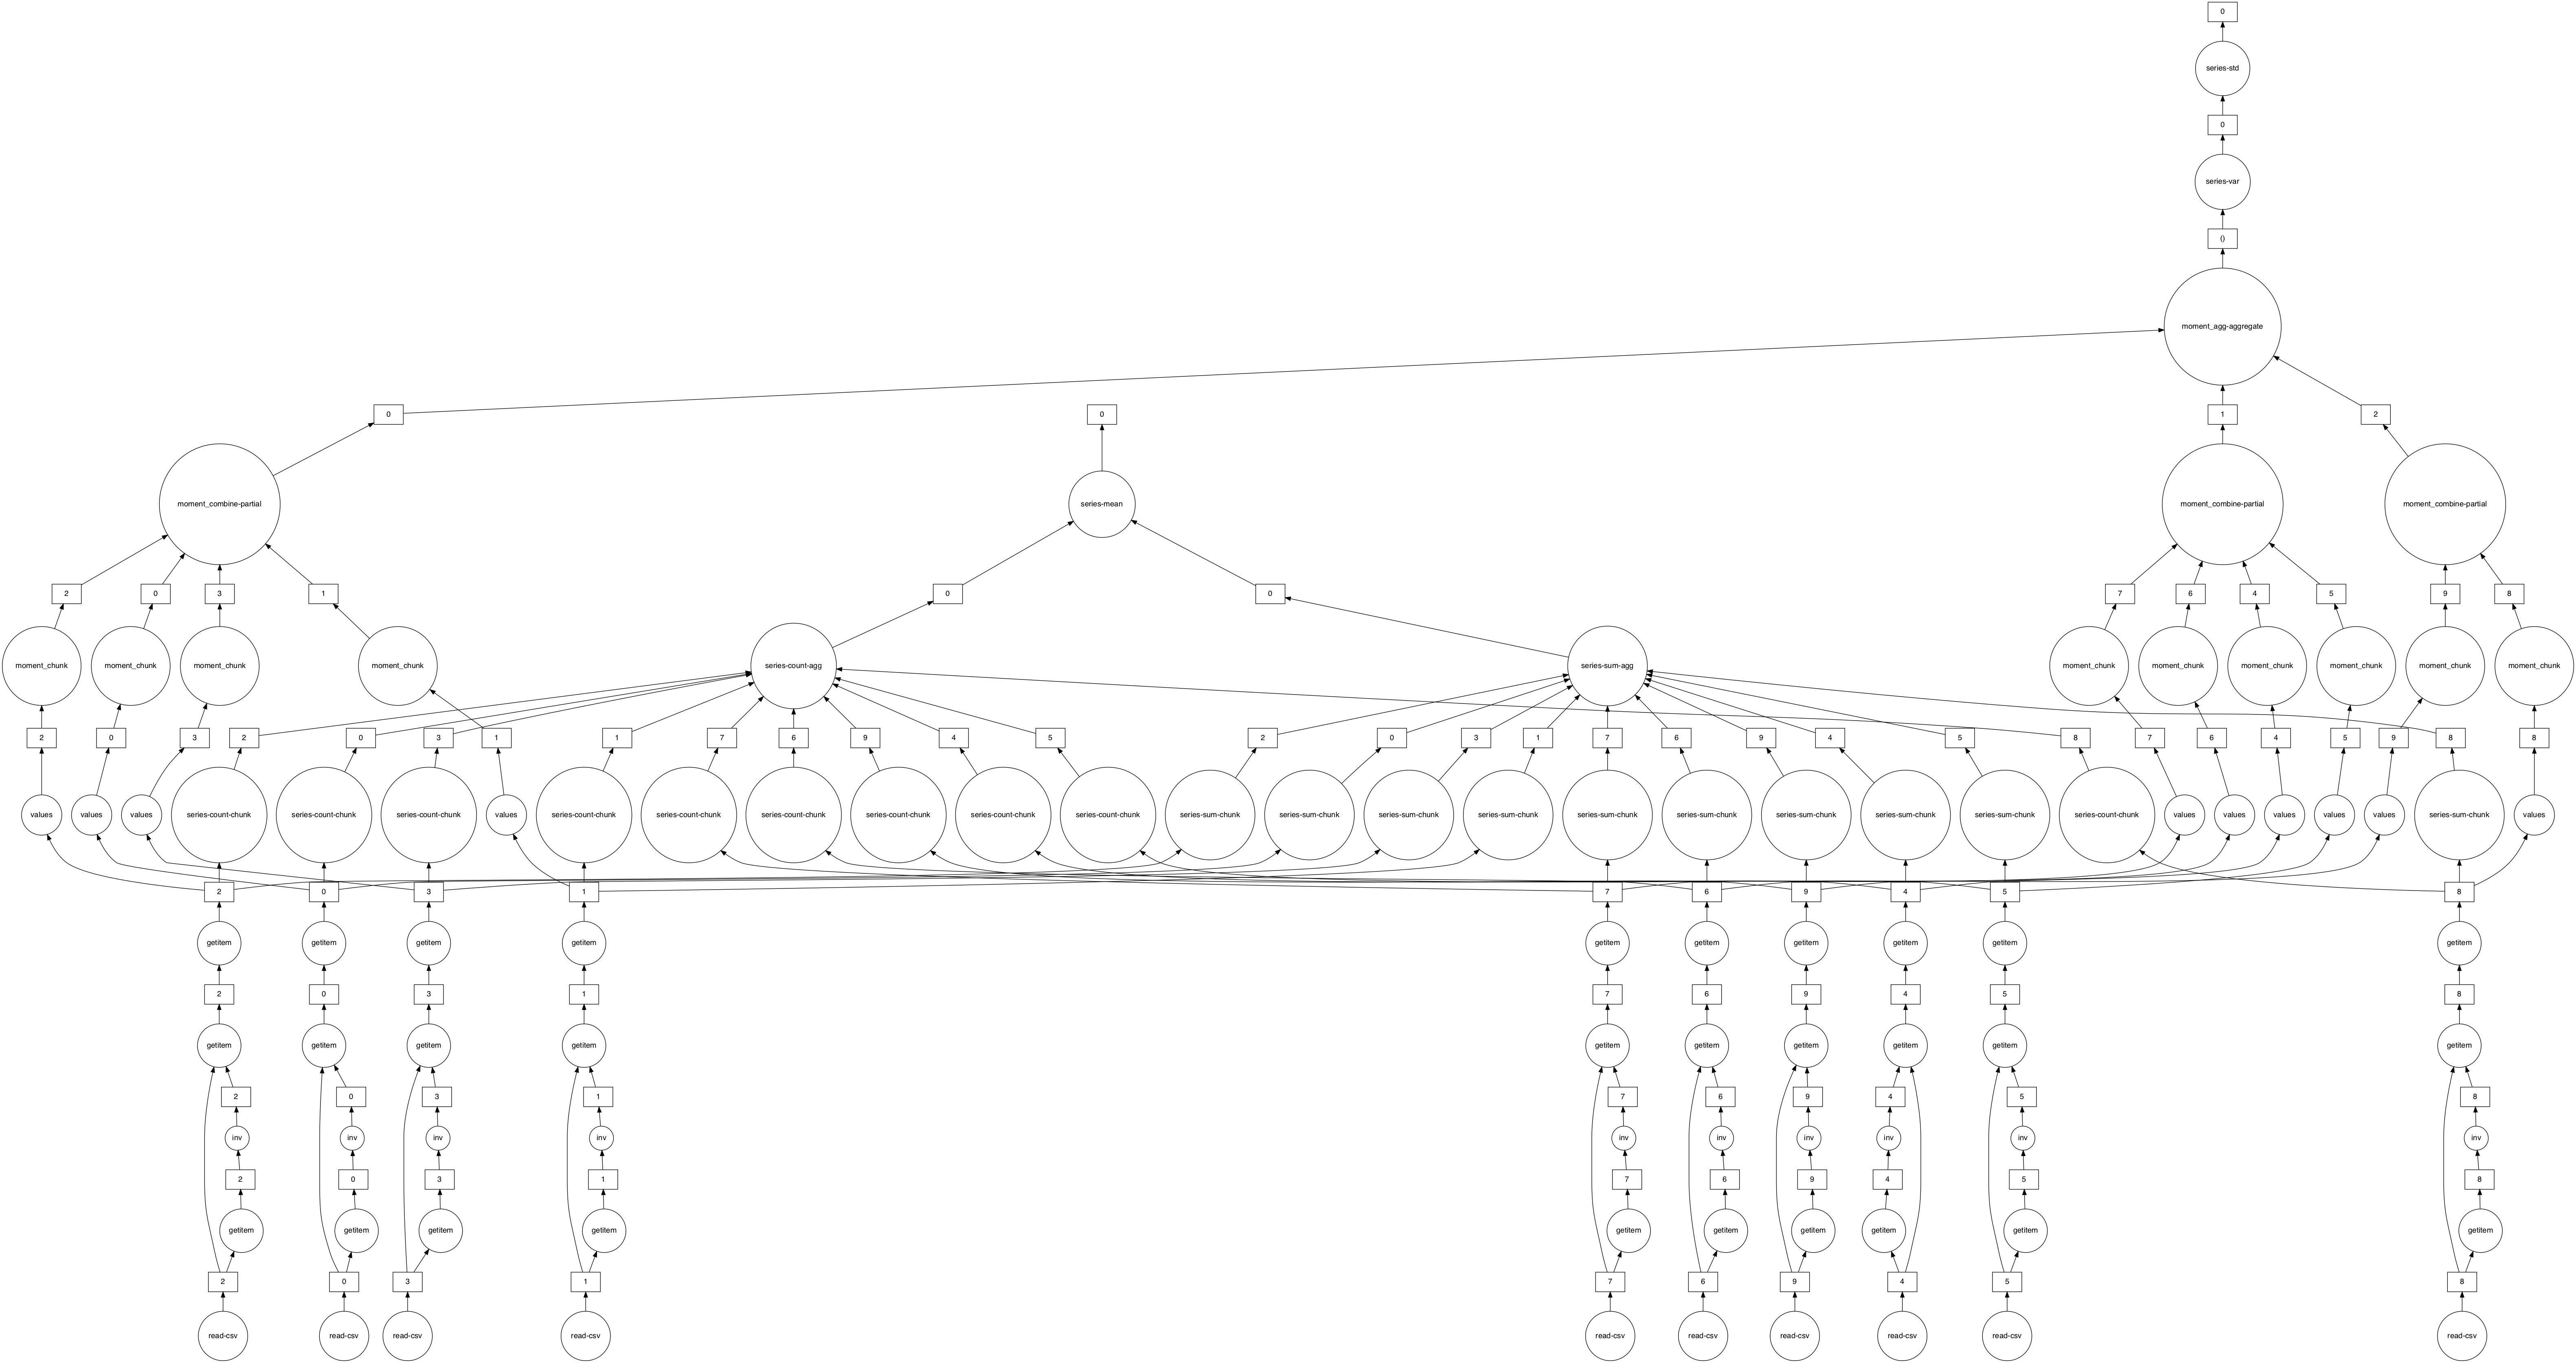

In [26]:
dask.visualize(mean_delay, std_delay)

### `persist`ing intermediate results

Sometimes, you may want to keep the intermediate results in memory for future computations, you can use the `.persist()` method to tell Dask to trigger a compute in the background. 

`.persist()` triggers a compute of intermediate "futures" (which is out of scope for this tutorial). You will get back a new DataFrame that is semantically equivalent to your old DataFrame, but now points to running data.

In [27]:
ddf = ddf.persist() # Notice the dashboard!

Keep in mind that using `.persist()` will occupy resources, and can also fill up your memory if not used carefully. Generally, you should use `persist` to keep (a) small data, (b) that is used very often, in memory.

## Best Practices

Let's discuss some best practices while using Dask DataFrame, selected from the [official documentation](https://docs.dask.org/en/stable/dataframe-best-practices.html).

### Re-partition for optimization

Often, the number of partitions in your Dask DataFrame is decided for you. For example, it might be the number of CSV files from which you are reading. However, over time, as you reduce or increase the size of your pandas DataFrames by filtering or joining, it may be wise to reconsider how many partitions you need.

There is a cost to having too many or having too few:
* Too many will add scheduling overhead
* Too few might cause memory errors

Partitions should fit comfortably in memory (smaller than a gigabyte) but also not be too many. You should aim for partitions that have around 100MB of data each.

You can use the `.repartition` method for this:

```python
ddf = ddf.repartition(partition_size="100MB")
```

### Avoid full-data shuffling

Setting an index is an important but expensive operation (see above). You should do it infrequently and you should persist afterwards.

In [28]:
client.close()

## Resources to learn more

- [Dask Tutorial -- DataFrames](https://github.com/dask/dask-tutorial/blob/main/04_dataframe.ipynb)
- [Dask DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
- [Dask DataFrame examples](https://examples.dask.org/dataframe.html)